# Lab 6 - Bayesian Networks

## A bit of statistics

### Basics
* The probability of an event is a value between 0 and 1 $0 \le P(A)\le 1$
* The probability of an event not conditioned by other events is also defined as **prior probability**
* The probability of an event and of its complementary sum to 1 $1 - P(A) = P(\bar{A})$
* The probability of the union of two events is equal to the sum of their prior probabilities minus the probability of their intersection $ P(A \cup B) = P(A) + P(B) - P(A \cap B)$
* If the events are **mutually exclusive**, the following holds
$P(A \cup B) = P(A) + P(B)$

### Independency
* A probability is called **conditional probability** if it depends from the occurrence of another event

$P(A|B) = \frac{P(A \cap B)}{P(B)} = \frac{P(A,B)}{P(B)}$

* The joint probability of two events is obtained by the moltiplication

$P(A \cap B) = P(B|A) P(A) = P(A|B) P(B)$

* If two events are **statistically independent**, the following holds 

$$P(A\cap B) = P(A) P(B) \;\;\;\text {since} \;\;P(A|B) = P(A)$$

### Bayes 
* Law of total probabilities: if $B_1, ..., B_k$ are a partition of the sample space $B$, then
$P(A) = \sum_{i=1}^{k} P(A|B_i) P(B_i)$

* **Bayes' theorem**
$ P(B|A) = \frac{P(A|B)P(B)}{P(A)}= \frac{P(A|B) P(B)}{P(A|B) P(B) + P(A|\bar{B})P(\bar{B})}$

## Graph Probabilistic Models
* The tables completely describe the scenario to be studied
 * E.g., 4 variables and 4 dependencies in the example below
* A Graph Probabilistic Model is a graphical representation of a set of conditional probabilities
 * Here, "cloudy" is independent, having no incoming arcs.

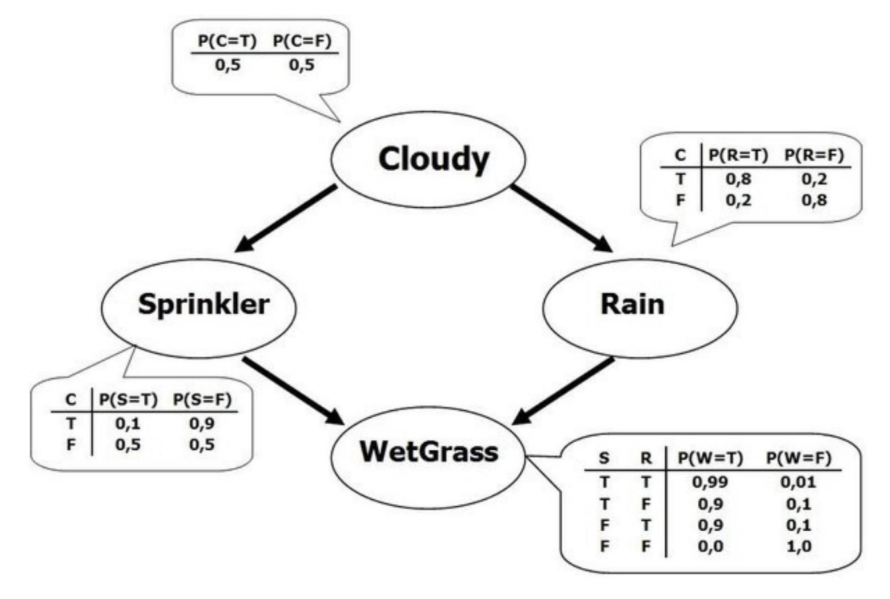

## Applications
* Diagnostic models: Onisko, Agnieszka et al. “[A Bayesian Network Model for Diagnosis of Liver Disorders](https://sites.pitt.edu/~druzdzel/psfiles/cbmi99a.pdf).” (1999).

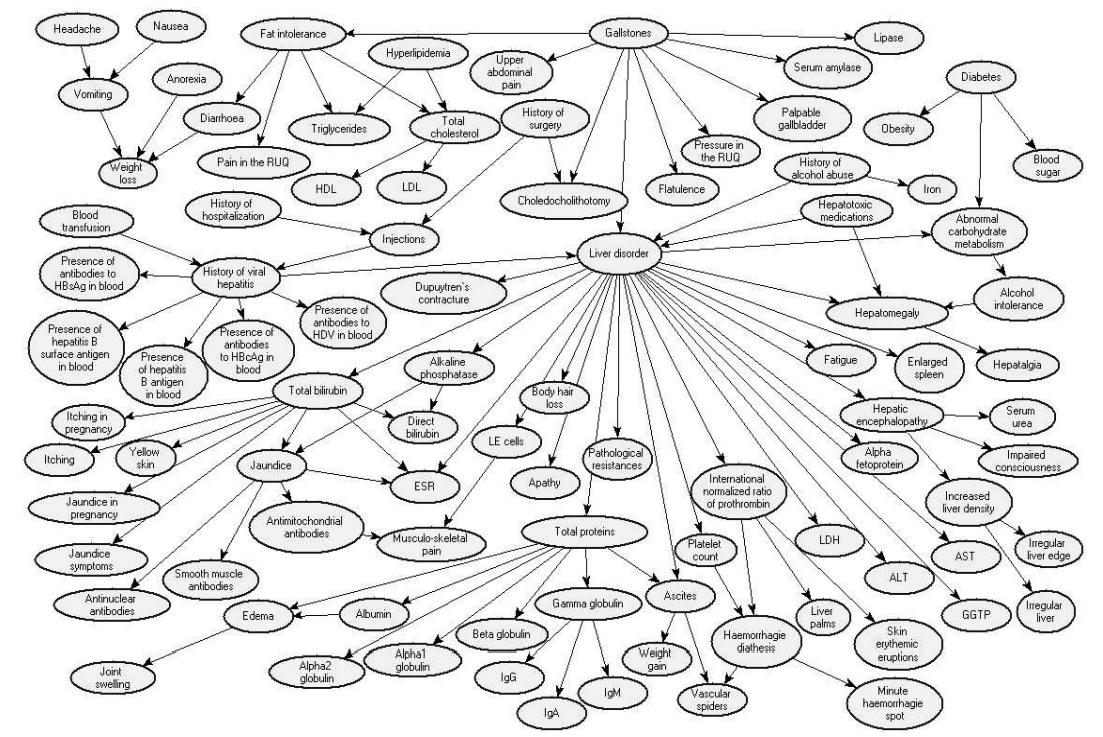

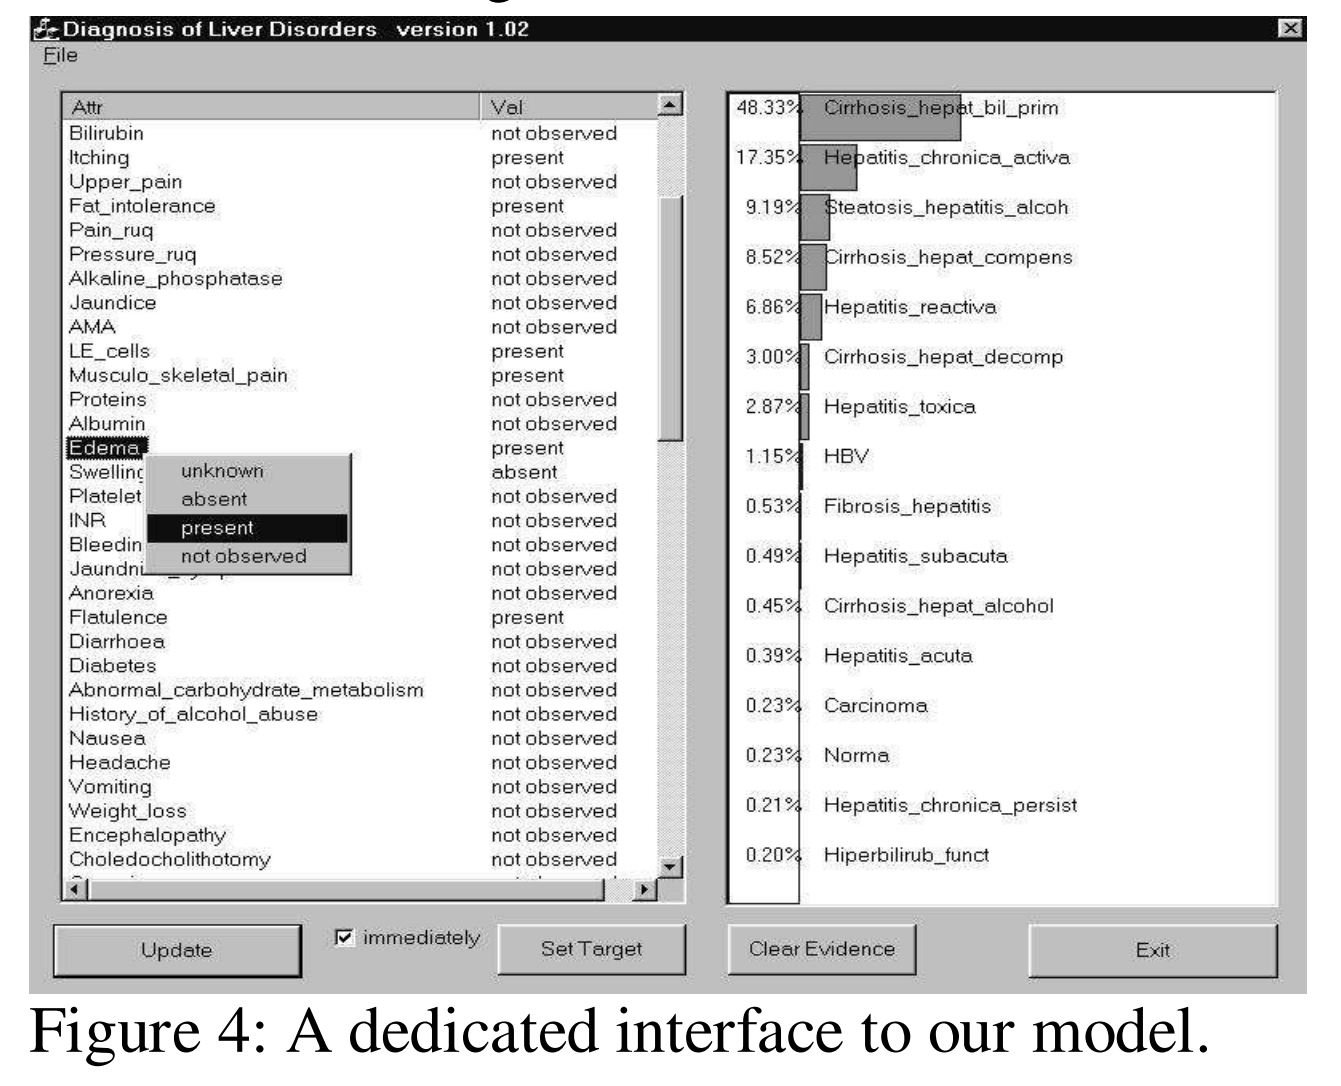

# Bayesian Network
* Computing joint probabilities is hard! 
 * E.g., if we have 10 discrete random variables which have 10 possible states  $\Rightarrow 10^{10}$ possible states overall 
 * We simplify the computation of joint probabilities assuming independence where possible

* The Bayesian network is a special case of a probabilistic
graph that exploits the principles of the Bayesian inference to
compute the joint probabilities (or the probability of the
intersection of events)
* We compute the joint distribution as the product of the conditional probabilities (CPD)
$$ P(X_1=x_1, ..., X_n = x_n) = \prod_i^n P(X_i=x_i | Parents(X_i))$$

## Properties
* A BN is a Direct Acyclic Graph (DAG) in which each node
corresponds to a stochastic variable and each connection
represents a conditional dependency
* Two nodes not connected are independent from each other
* Each variable X in the model is associated to a conditional
probability distribution (CPD): it specifies a probability for each
value in the domain of X for each joint assignment of a value to its
parents
* For a node without parents, the CPD is conditioned to an empty
set of variables and can be considered a distribution of marginal
probabilities (or prior probabilities)

## Bayesian inference
1. Find the joint probability of all or a subset of the variables in the
problem
$P(x)$ with $x = \{x_1,...,x_n\}$ → Chain rule

2. Find the conditional probability of one or a subset of variables
(x) in the problem given the assignment to other variables (or
evidence, e)
$P(x|e)$ → Solution by enumeration or deletion

# PgmPy
PgmPy (Probabilistic Graphical Model Python) is a popular Python package which provides advanced tools to build and learn Bayesian Networks.

In [ ]:
!pip install pgmpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 7.6 MB/s 


# An example
Consider the classic Earthquake problem.

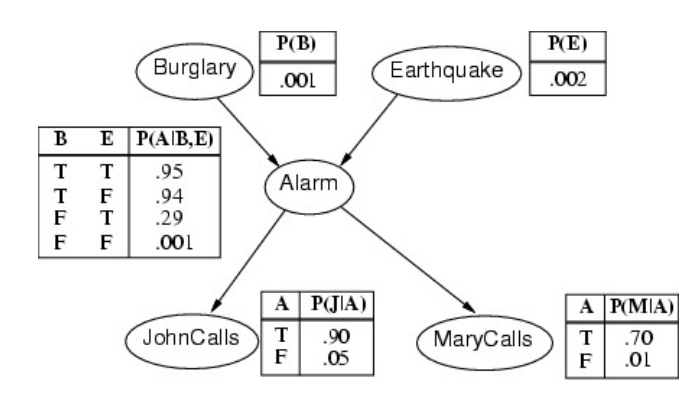

First, we define the network structure.

In [ ]:
# Defining network structure
from pgmpy.models import BayesianNetwork

alarm_model = BayesianNetwork(
    [
        ("Burglary", "Alarm"),
        ("Earthquake", "Alarm"),
        ("Alarm", "JohnCalls"),
        ("Alarm", "MaryCalls"),
    ]
)

Then, we visualize the network.

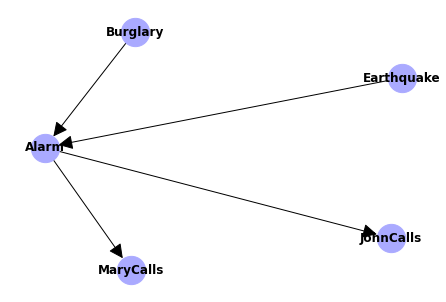

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

def draw_pgm(model):
    pos = nx.circular_layout(sorted(model))

    return nx.draw(
        model, with_labels=True, arrowsize=30, node_size=800, alpha=1, font_weight="bold", node_color="#aaaaff")

draw_pgm(alarm_model)

## CPDs
To model this problem, we are provided with the CPDs (Conditional Probability Distributions).

 We need to create them in `pgmpy`, making sure to follow the correct order.

In [ ]:
# Defining the parameters using CPT
from pgmpy.factors.discrete import TabularCPD

cpd_burglary = TabularCPD(
    variable="Burglary", 
    variable_card=2,  # cardinality. here, B has the values {0, 1}.

    # first we specify the value of B=0, then B=1
    values=[[0.999],[0.001]]  
)

cpd_earthquake = TabularCPD(
    variable="Earthquake", variable_card=2, values=[[0.998],[0.002]]
)

cpd_alarm = TabularCPD(
    variable="Alarm",
    variable_card=2,

    # we specifify probabilities according to the evidence order below;
    # here, (A=0,B=0,E=0) is the first value, then (A=0,B=0,E=1), then (A=0,B=1,E=0), ...
    values=[
            [0.999, 0.71, 0.06, 0.05],  # A=0
            [0.001, 0.29, 0.94, 0.95]   # A=1
            ],
    evidence=["Burglary", "Earthquake"],
    evidence_card=[2, 2],  # cardinality
)

cpd_johncalls = TabularCPD(
    variable="JohnCalls",
    variable_card=2,
    values=[[0.95, 0.1], 
            [0.05, 0.9]],
    evidence=["Alarm"],
    evidence_card=[2],
)

cpd_marycalls = TabularCPD(
    variable="MaryCalls",
    variable_card=2,
    values=[[0.99, 0.3], [0.01, 0.7]],
    evidence=["Alarm"],
    evidence_card=[2],
)

# Associating the parameters with the model structure
alarm_model.add_cpds(
    cpd_burglary, cpd_earthquake, cpd_alarm, cpd_johncalls, cpd_marycalls
)


## Inference

We can perform exact inference by both enumeration and variable elimination.

* In general, $P(X|e) = \alpha P(X,e) = \alpha \sum_y P(X,e,y) $, given $y$ as the unobserved variables, $e$ as the evidence, and $X$ the query.

* We use $P(j)$ to indicate $P(J=1)$.

* $P(B|j,m) = \alpha P(B,j,m)$, as the joint probability is proportional to the conditional probability, given $P(j,m)$ is just a normalization constant 

* Then, $P(B,j,m) = \sum_e \sum_a P(B,j,m,e,a)$ to consider each variable unobserved $y$ in the network 

* Then, we can find the joint distribution with the formula $ P(X_1=x_1, ..., X_n = x_n) = \prod_i^n P(X_i=x_i | Parents(X_i))$

* In this case, $P(B,j,m) = \sum_e \sum_a P(B) P(e) P(a|B,e) P(j|a) P(m|a)$


* Now we compute the conditional probability, using $\alpha$ and moving $P(B)$ out of the sums: $P(B|j,m) = \alpha P(B) \sum_e P(e) \sum_a P(a|B,e) P(j|a) P(m|a)$ 

$$... = (0.284,0.716)$$

(Cfr. Chapter 14 of "Artificial Intelligence, a Modern Approach" for the full derivation and the algorithm)

Variable elimination can help in reducing the overall computations required. The method works bottom up, by storing intermediate results for later use. 


In [ ]:
# Infering the posterior probability
from pgmpy.inference import VariableElimination

infer = VariableElimination(alarm_model)

posterior_p = infer.query(["Burglary"], evidence={"JohnCalls": 1, "MaryCalls": 1})
print(posterior_p)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

+-------------+-----------------+
| Burglary    |   phi(Burglary) |
+=============+=================+
| Burglary(0) |          0.7158 |
+-------------+-----------------+
| Burglary(1) |          0.2842 |
+-------------+-----------------+


# Exercise 1: The Monty-Hall problem
The Monty-Hall problem is a classic in probability theory, since the optimal decision is somewhat counterintuitive.

> Suppose you're on a game show, and you're given the choice of three doors: Behind one door is a car; behind the others, goats. You pick a door, say No. 1, and the host, who knows what's behind the doors, opens another door, say No. 3, which has a goat. He then says to you, "Do you want to pick door No. 2?" Is it to your advantage to switch your choice?

This classic problem can be easily solved by a Bayesian Network.

Let's define the following:

* $\{0,1,2\}$ are the possible doors to choose from
* $C$ is a random variable containing the door chosen by the contestant
* $P$ is a random variable containing the door that has the prize
* $H$ is a random variable containing the door selected by the host.




## Exercise 1.1
First of all, define the network. 

### Solution
The choice of the host is clearly influenced by the contestant and by the prize position, while there should not be any dependency between the prize door and the contestant door.

In [ ]:
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD

# Defining the network structure
model = BayesianNetwork([("C", "H"), ("P", "H")])

## Exercise 1.2
Visualize the network.

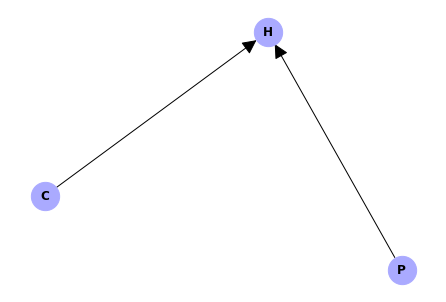

In [ ]:
draw_pgm(model)

## Exercise 1.3
Define the CPDs with pgmpy.

### Solution 
Using the library we can define directly the CPDs (Conditional Probability Distributions) by hand.



In [ ]:
# Defining the CPDs:
cpd_c = TabularCPD("C", 3, [[0.33], [0.33], [0.33]])
cpd_p = TabularCPD("P", 3, [[0.33], [0.33], [0.33]])
cpd_h = TabularCPD(
    "H",
    3,
    [
        [0, 0, 0, 0, 0.5, 1, 0, 1, 0.5],  # door #0
        [0.5, 0, 1, 0, 0, 0, 1, 0, 0.5],  # door #1
        [0.5, 1, 0, 1, 0.5, 0, 0, 0, 0],  # door #2
    ],
    evidence=["C", "P"],  # list of variables needed as input to compute the conditional probabilities
    evidence_card=[3, 3],  # contains the cardinality of each variable needed as input
)
# Associating the CPDs with the network structure.
model.add_cpds(cpd_c, cpd_p, cpd_h)

In [ ]:
# print the probability tables
for cpd in model.get_cpds():
    print(cpd)

+------+------+
| C(0) | 0.33 |
+------+------+
| C(1) | 0.33 |
+------+------+
| C(2) | 0.33 |
+------+------+
+------+------+
| P(0) | 0.33 |
+------+------+
| P(1) | 0.33 |
+------+------+
| P(2) | 0.33 |
+------+------+
+------+------+------+------+------+------+------+------+------+------+
| C    | C(0) | C(0) | C(0) | C(1) | C(1) | C(1) | C(2) | C(2) | C(2) |
+------+------+------+------+------+------+------+------+------+------+
| P    | P(0) | P(1) | P(2) | P(0) | P(1) | P(2) | P(0) | P(1) | P(2) |
+------+------+------+------+------+------+------+------+------+------+
| H(0) | 0.0  | 0.0  | 0.0  | 0.0  | 0.5  | 1.0  | 0.0  | 1.0  | 0.5  |
+------+------+------+------+------+------+------+------+------+------+
| H(1) | 0.5  | 0.0  | 1.0  | 0.0  | 0.0  | 0.0  | 1.0  | 0.0  | 0.5  |
+------+------+------+------+------+------+------+------+------+------+
| H(2) | 0.5  | 1.0  | 0.0  | 1.0  | 0.5  | 0.0  | 0.0  | 0.0  | 0.0  |
+------+------+------+------+------+------+------+------

## Exercise 1.4
Use pgmpy to:
* Calculate the probability $P(P|C=0,H=2)$




In [ ]:
# Infering the posterior probability
from pgmpy.inference import VariableElimination

infer = VariableElimination(model)
posterior_p = infer.query(["P"], evidence={"C": 0, "H": 2})
print(posterior_p)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

+------+----------+
| P    |   phi(P) |
+======+==========+
| P(0) |   0.3333 |
+------+----------+
| P(1) |   0.6667 |
+------+----------+
| P(2) |   0.0000 |
+------+----------+


# Inferring from data
Using `pgmpy` we can build Bayesian models inferred from data. The library lets us to perform:
1. Parameter learning
2. Structure learning

## Parameter learning
We use parameter learning if we have an underlying structure already defined, and we wish to discover the corresponding CPDs.

Here, we have a very simple dataset with 14 observations, where we judged the quality of different fruits.

In [ ]:
import pandas as pd
data = pd.DataFrame(data={'fruit': ["banana", "apple", "banana", "apple", "banana","apple", "banana",
                                    "apple", "apple", "apple", "banana", "banana", "apple", "banana",],
                          'tasty': ["yes", "no", "yes", "yes", "yes", "yes", "yes",
                                    "yes", "yes", "yes", "yes", "no", "no", "no"],
                          'size': ["large", "large", "large", "small", "large", "large", "large",
                                    "small", "large", "large", "large", "large", "small", "small"]})
print(data)


     fruit tasty   size
0   banana   yes  large
1    apple    no  large
2   banana   yes  large
3    apple   yes  small
4   banana   yes  large
5    apple   yes  large
6   banana   yes  large
7    apple   yes  small
8    apple   yes  large
9    apple   yes  large
10  banana   yes  large
11  banana    no  large
12   apple    no  small
13  banana    no  small


We define the following network structure: 
* a tasty fruit depends on the fruit chosen
* the size of the fruit influences its taste.

In [ ]:
from pgmpy.models import BayesianNetwork

model = BayesianNetwork([('fruit', 'tasty'), ('size', 'tasty')])  # fruit -> tasty <- size


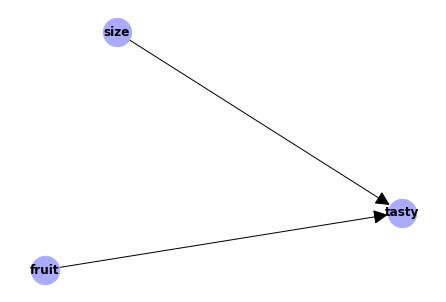

In [ ]:
draw_pgm(model)

In [ ]:
from pgmpy.estimators import ParameterEstimator
pe = ParameterEstimator(model, data)
print("\n", pe.state_counts('fruit'))  # unconditional
print("\n", pe.state_counts('tasty'))  # conditional on fruit and size


         fruit
apple       7
banana      7

 fruit apple       banana      
size  large small  large small
tasty                         
no      1.0   1.0    1.0   1.0
yes     3.0   2.0    5.0   0.0


We can select the probabilities using the maximum likelihood estimator, which reduces to the simple frequency count.


In [ ]:
from pgmpy.estimators import MaximumLikelihoodEstimator
mle = MaximumLikelihoodEstimator(model, data)
print(mle.estimate_cpd('fruit'))  # unconditional
result = mle.estimate_cpd('tasty')  # conditional
print(result)
print(result.values)

+---------------+-----+
| fruit(apple)  | 0.5 |
+---------------+-----+
| fruit(banana) | 0.5 |
+---------------+-----+
+------------+--------------+-----+---------------+
| fruit      | fruit(apple) | ... | fruit(banana) |
+------------+--------------+-----+---------------+
| size       | size(large)  | ... | size(small)   |
+------------+--------------+-----+---------------+
| tasty(no)  | 0.25         | ... | 1.0           |
+------------+--------------+-----+---------------+
| tasty(yes) | 0.75         | ... | 0.0           |
+------------+--------------+-----+---------------+
[[[0.25       0.33333333]
  [0.16666667 1.        ]]

 [[0.75       0.66666667]
  [0.83333333 0.        ]]]


We can fit a model using the estimator.

In [ ]:
# Calibrate all CPDs of `model` using MLE:
model.fit(data, estimator=MaximumLikelihoodEstimator)

We can use it to compute new predictions.

In [ ]:
data_to_predict = pd.DataFrame(data={'tasty':['yes', 'no'], 'size':['small','small']})
model.predict(data_to_predict)

  0%|          | 0/2 [00:00<?, ?it/s]

,fruit
0,apple
1,banana


Using the simple Maximum Likelihood criteria, we risk overfitting the data if we have few samples: if we have seen only one small banana, how could we conclude that **all** small bananas are not tasty?

A simple way to avoid this is by employing different priors: for example, the K2 prior is used to compute an additional pseudo-count for each state, in order to make more conservative predictions. A more advanced prior is BDeu.

In [ ]:
from pgmpy.estimators import BayesianEstimator
est = BayesianEstimator(model, data)
result = est.estimate_cpd('tasty', prior_type='K2')
print(result)
print(result.values)

+------------+--------------------+-----+--------------------+
| fruit      | fruit(apple)       | ... | fruit(banana)      |
+------------+--------------------+-----+--------------------+
| size       | size(large)        | ... | size(small)        |
+------------+--------------------+-----+--------------------+
| tasty(no)  | 0.3333333333333333 | ... | 0.6666666666666666 |
+------------+--------------------+-----+--------------------+
| tasty(yes) | 0.6666666666666666 | ... | 0.3333333333333333 |
+------------+--------------------+-----+--------------------+
[[[0.33333333 0.4       ]
  [0.25       0.66666667]]

 [[0.66666667 0.6       ]
  [0.75       0.33333333]]]


## Structure learning
If a structure of the network is not given, it is possible to explore the whole network space to find a good structure.


In [ ]:
from pgmpy.estimators import ExhaustiveSearch
from pgmpy.estimators import BDeuScore, K2Score, BicScore
import numpy as np
# create random data sample with 3 variables, where Z is dependent on X, Y:
data = pd.DataFrame(np.random.randint(0, 4, size=(5000, 2)), columns=list('XY'))
data['Z'] = data['X'] + data['Y']

bdeu = BDeuScore(data, equivalent_sample_size=5)
k2 = K2Score(data)
bic = BicScore(data)
print(data)

      X  Y  Z
0     1  0  1
1     0  1  1
2     1  2  3
3     1  0  1
4     3  0  3
...  .. .. ..
4995  0  2  2
4996  2  3  5
4997  3  1  4
4998  3  2  5
4999  2  1  3

[5000 rows x 3 columns]


In [ ]:
from pgmpy.estimators import ExhaustiveSearch

es = ExhaustiveSearch(data, scoring_method=bic)
best_model = es.estimate()
print(best_model.edges())

print("\nAll DAGs by score:")
for score, dag in reversed(es.all_scores()):
    print(score, dag.edges())


[('X', 'Z'), ('Y', 'Z')]

All DAGs by score:
-14295.728523578853 [('X', 'Z'), ('Y', 'Z')]
-14332.000816127505 [('Y', 'Z'), ('Y', 'X'), ('Z', 'X')]
-14332.000816127505 [('X', 'Z'), ('Y', 'Z'), ('Y', 'X')]
-14332.000816127507 [('Y', 'X'), ('Z', 'X'), ('Z', 'Y')]
-14332.000816127507 [('X', 'Y'), ('Z', 'X'), ('Z', 'Y')]
-14332.000816127507 [('X', 'Y'), ('X', 'Z'), ('Z', 'Y')]
-14332.000816127507 [('X', 'Y'), ('X', 'Z'), ('Y', 'Z')]
-16511.615575375552 [('Y', 'X'), ('Z', 'X')]
-16511.94455664456 [('X', 'Y'), ('Z', 'Y')]
-18737.95107740091 [('Z', 'X'), ('Z', 'Y')]
-18737.95107740091 [('Y', 'Z'), ('Z', 'X')]
-18737.95107740091 [('X', 'Z'), ('Z', 'Y')]
-20917.56583664896 [('Z', 'X')]
-20917.56583664896 [('X', 'Z')]
-20917.894817917964 [('Z', 'Y')]
-20917.894817917964 [('Y', 'Z')]
-20953.83812919761 [('X', 'Z'), ('Y', 'X')]
-20953.83812919761 [('X', 'Y'), ('Z', 'X')]
-20953.83812919761 [('X', 'Y'), ('X', 'Z')]
-20954.167110466617 [('Y', 'X'), ('Z', 'Y')]
-20954.167110466617 [('Y', 'Z'), ('Y', '

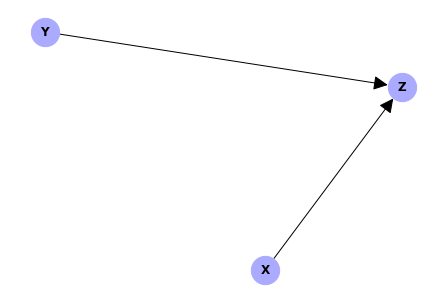

In [ ]:
draw_pgm(best_model)

In [ ]:
from pgmpy.estimators import HillClimbSearch

# create some data with dependencies
data = pd.DataFrame(np.random.randint(0, 3, size=(2500, 8)), columns=list('ABCDEFGH'))
data['A'] += data['B'] + data['C']
data['H'] = data['G'] - data['A']

hc = HillClimbSearch(data)
best_model = hc.estimate(scoring_method=BicScore(data))
print(best_model.edges())


  0%|          | 0/1000000 [00:00<?, ?it/s]

[('A', 'C'), ('A', 'B'), ('B', 'C'), ('G', 'A'), ('H', 'A'), ('H', 'G')]


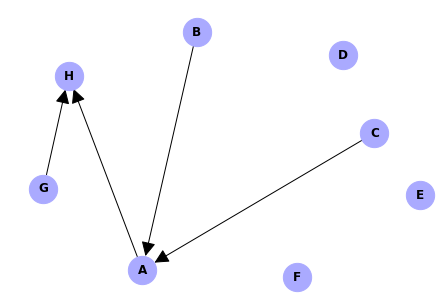

In [ ]:
true_model = BayesianNetwork()

true_model.add_nodes_from('ABCDEFGH')

true_model.add_edge('B','A')
true_model.add_edge('C', 'A')
true_model.add_edge('G', 'H')
true_model.add_edge('A','H')
draw_pgm(true_model)

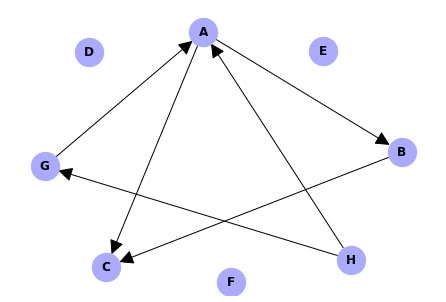

In [ ]:
draw_pgm(best_model)

# Titanic dataset
* The sinking of the RMS Titanic was one of the most dire naval
disasters in history. On the night between 14 and 15 April 1912,
during the inauguration voyage, the Titanic sank after colliding with
an iceberg, killing 1502 people out of a total of 2224 passengers
and personnel. The tragedy shocked the international community,
leading to better regulation of ship safety.

* International Convention for the Protection of Human Life at Sea
(SOLAS Treaty), in force since 1914 in response to the sinking of
the Titanic.
* It includes a minimum number of lifeboats, other safety equipment
and procedures, including radio monitoring.

One of the main reasons that led to such a huge loss of life was the
shortage of lifeboats.
Even if some unpredictable factors are clearly involved in the survival of each passenger, we can see how some groups of people were more or
less involved, such as women, children and the first classes.

* Load the dataset
* Explore the data and find eventual dependencies between the
variables
* Create the graph of dependencies
* For each variable, compute the CPD

In [ ]:
!wget https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv

--2022-05-27 10:01:18--  https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv
Resolving web.stanford.edu (web.stanford.edu)... 171.67.215.200, 2607:f6d0:0:925a::ab43:d7c8
Connecting to web.stanford.edu (web.stanford.edu)|171.67.215.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44225 (43K) [text/csv]
Saving to: ‘titanic.csv’

titanic.csv         100%[===================>]  43.19K  --.-KB/s    in 0.04s   

2022-05-27 10:01:18 (1.11 MB/s) - ‘titanic.csv’ saved [44225/44225]



In [ ]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style
from sklearn.preprocessing import LabelEncoder
import numpy as np

import networkx as nx

Load the dataset

In [ ]:
df = pd.read_csv("titanic.csv", sep=",")

In [ ]:
df.describe()

,Survived,Pclass,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
count,887.000000,887.000000,887.000000,887.000000,887.000000,887.00000
mean,0.385569,2.305524,29.471443,0.525366,0.383315,32.30542
std,0.487004,0.836662,14.121908,1.104669,0.807466,49.78204
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.00000
25%,0.000000,2.000000,20.250000,0.000000,0.000000,7.92500
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.45420
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.13750
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.32920


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc62408b210>,
      dtype=object)

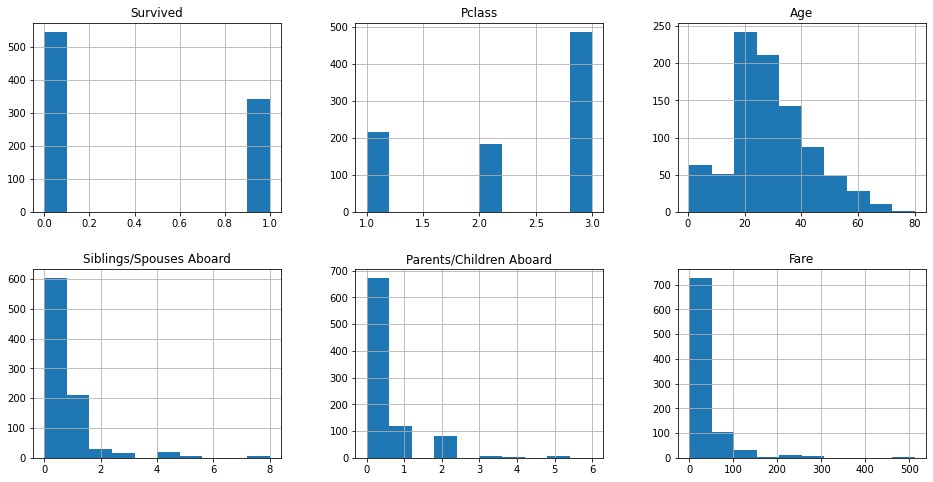

In [ ]:
fig, axis = plt.subplots(2,3,figsize=(16, 8))
df.hist(ax=axis)

In [ ]:
df = df[['Survived', 'Pclass','Sex', 'Fare', 'Age']]
df.info()

df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887 entries, 0 to 886
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  887 non-null    int64  
 1   Pclass    887 non-null    int64  
 2   Sex       887 non-null    object 
 3   Fare      887 non-null    float64
 4   Age       887 non-null    float64
dtypes: float64(2), int64(2), object(1)
memory usage: 34.8+ KB


,Survived,Pclass,Fare,Age
count,887.000000,887.000000,887.00000,887.000000
mean,0.385569,2.305524,32.30542,29.471443
std,0.487004,0.836662,49.78204,14.121908
min,0.000000,1.000000,0.00000,0.420000
25%,0.000000,2.000000,7.92500,20.250000
50%,0.000000,3.000000,14.45420,28.000000
75%,1.000000,3.000000,31.13750,38.000000
max,1.000000,3.000000,512.32920,80.000000


In [ ]:
# CHANGE LABEL MALE/FEMALE IN 0/1
genders = {"male": 0, "female": 1}
df['Sex'] = df['Sex'].map(genders)

In [ ]:
# CHANGE LABEL FARE IN CHEAP/EXPENSIVE 0 if <30, 1 if >30
# df.loc[:,'Fare'] = pd.cut(df.Fare, [df.Fare.min(),30, df.Fare.max()], labels =[0,1])
df['Fare'] = df['Fare'].apply(lambda fare: 0 if fare < 30 else 1)

In [ ]:
from sklearn.preprocessing import KBinsDiscretizer
est = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
est.fit(df['Age'].to_numpy().reshape(-1, 1))

df['Age'] = est.transform(df['Age'].to_numpy().reshape(-1, 1))

In [ ]:
df.describe()

,Survived,Pclass,Sex,Fare,Age
count,887.000000,887.000000,887.000000,887.000000,887.000000
mean,0.385569,2.305524,0.354002,0.270575,1.005637
std,0.487004,0.836662,0.478480,0.444507,0.820843
min,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,0.000000,0.000000
50%,0.000000,3.000000,0.000000,0.000000,1.000000
75%,1.000000,3.000000,1.000000,1.000000,2.000000
max,1.000000,3.000000,1.000000,1.000000,2.000000


## Useful commands

In [ ]:
test = pd.DataFrame({'A': [1,2,3], 'B': [4,5,6]})
test

,A,B
0,1,4
1,2,5
2,3,6


In [ ]:
test[test['A'] > 1]

,A,B
1,2,5
2,3,6


In [ ]:
len(test[test['A'] > 1])

2

In [ ]:
test[(test['A'] > 1) & (test['B'] < 6)]

,A,B
1,2,5


## Exercise 2.1
Specify the following network and use the Maximum Likelihood Estimator to fit a model to estimate the CPD.

Query the following quantities:

* P(Survived | Sex=0)
* P(Pclass | Fare=0)
* P(Survived | Fare=1)
* P(Survived | Pclass=1, Sex=1)

Calculate all the quantities that can be computed as simple frequency counts.

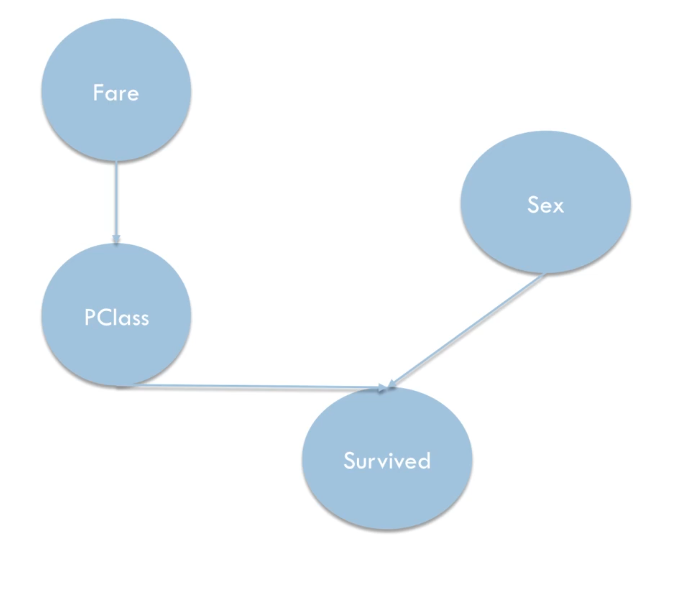

Solution: use $P(A|B) = \frac{P(A,B)}{P(B)}$

In [ ]:
model = BayesianNetwork([("Fare", "Pclass"), ("Sex", "Survived"), ("Pclass", "Survived")])

In [ ]:
model.fit(df, estimator=MaximumLikelihoodEstimator)

P(Survived | Sex=0)

In [ ]:
infer = VariableElimination(model)
# this quantity cannot be computed as frequency count since it needs to have information from PClass
print(infer.query(["Survived"], evidence={"Sex": 0}))

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

+-------------+-----------------+
| Survived    |   phi(Survived) |
+=============+=================+
| Survived(0) |          0.8023 |
+-------------+-----------------+
| Survived(1) |          0.1977 |
+-------------+-----------------+


In [ ]:
len(df[(df['Survived'] == 0) & (df['Sex'] == 0)]) / (df['Sex'] == 0).sum()

0.8097731239092496

P(Pclass | Fare=0)

In [ ]:
# this can be computed as frequency count since no other nodes are involved
print(infer.query(["Pclass"], evidence={"Fare": 0}))

0it [00:00, ?it/s]

0it [00:00, ?it/s]

+-----------+---------------+
| Pclass    |   phi(Pclass) |
+===========+===============+
| Pclass(1) |        0.0649 |
+-----------+---------------+
| Pclass(2) |        0.2457 |
+-----------+---------------+
| Pclass(3) |        0.6893 |
+-----------+---------------+


In [ ]:
# just for pclass = 2, but can be redone for all the values
len(df[(df['Pclass'] == 2) & (df['Fare'] == 0)]) / (df['Fare'] == 0).sum()

0.24574961360123648

P(survived|fare=1)

In [ ]:
# to find this value, we need to calculate P(survived | Pclass) * P(Pclass | fare)
print(infer.query(["Survived"], evidence={"Fare": 1}))

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

+-------------+-----------------+
| Survived    |   phi(Survived) |
+=============+=================+
| Survived(0) |          0.4889 |
+-------------+-----------------+
| Survived(1) |          0.5111 |
+-------------+-----------------+


In [ ]:
len(df[(df['Survived'] == 0) & (df['Fare'] == 1)]) / (df['Fare'] == 1).sum()

0.4125

P(survived| Pclass=1, Sex=1)

In [ ]:
print(infer.query(["Survived"], evidence={"Pclass": 1, "Sex": 1}))

0it [00:00, ?it/s]

0it [00:00, ?it/s]

+-------------+-----------------+
| Survived    |   phi(Survived) |
+=============+=================+
| Survived(0) |          0.0319 |
+-------------+-----------------+
| Survived(1) |          0.9681 |
+-------------+-----------------+


In [ ]:
# this can be computed as frequency count since we have all the ancestors of survived
len(df[(df['Survived'] == 1) & (df['Sex'] == 1) & (df['Pclass'] == 1)])  / len(df[(df['Sex'] == 1) & (df['Pclass'] == 1)])

0.9680851063829787

In [ ]:
from pgmpy.estimators import MaximumLikelihoodEstimator
mle = MaximumLikelihoodEstimator(model, df)
print(mle.estimate_cpd('Sex'))
print(mle.estimate_cpd('Pclass'))

result = mle.estimate_cpd('Survived')


+--------+----------+
| Sex(0) | 0.645998 |
+--------+----------+
| Sex(1) | 0.354002 |
+--------+----------+
+-----------+---------------------+---------------------+
| Fare      | Fare(0)             | Fare(1)             |
+-----------+---------------------+---------------------+
| Pclass(1) | 0.06491499227202473 | 0.725               |
+-----------+---------------------+---------------------+
| Pclass(2) | 0.24574961360123648 | 0.10416666666666667 |
+-----------+---------------------+---------------------+
| Pclass(3) | 0.6893353941267388  | 0.17083333333333334 |
+-----------+---------------------+---------------------+


In [ ]:
from itertools import product

for pclass, sex, survived in product([1,2,3],[0,1],[0,1]):
    print(f"pclass={pclass}, sex={sex}, surv={survived}:\t {result.values[survived,pclass-1,sex]:4f}")

pclass=1, sex=0, surv=0:	 0.631148
pclass=1, sex=0, surv=1:	 0.368852
pclass=1, sex=1, surv=0:	 0.031915
pclass=1, sex=1, surv=1:	 0.968085
pclass=2, sex=0, surv=0:	 0.842593
pclass=2, sex=0, surv=1:	 0.157407
pclass=2, sex=1, surv=0:	 0.078947
pclass=2, sex=1, surv=1:	 0.921053
pclass=3, sex=0, surv=0:	 0.862974
pclass=3, sex=0, surv=1:	 0.137026
pclass=3, sex=1, surv=0:	 0.500000
pclass=3, sex=1, surv=1:	 0.500000


In [ ]:
data_to_predict = df[['Survived', 'Pclass', 'Sex', 'Fare']].copy()
data_to_predict.drop('Survived', axis=1, inplace=True)
y_pred = model.predict(data_to_predict, stochastic=False)

In [ ]:
from sklearn.metrics import accuracy_score
y_true = df['Survived']
accuracy_score(y_pred, y_true)

In [ ]:
from pgmpy.estimators import BayesianEstimator

model.fit(df, estimator=BayesianEstimator, prior_type="BDeu", equivalent_sample_size=10)
for cpd in model.get_cpds():
    print(cpd)


## Exercise 2.2
Create another model which uses the K2 prior.

Compare P(Survived | Pclass=1) to the MLE model for increasing dataset sizes. (use `df.sample(n=N, random_state=N)` to create subsets of the data), and `plt.plot(X, Y)` to plot the values).



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

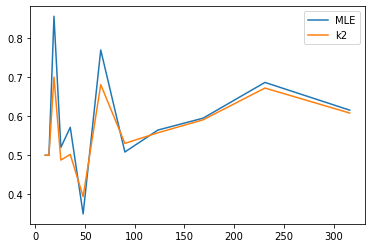

In [ ]:
#@title Solution
import matplotlib.pyplot as plt
from pgmpy.inference import VariableElimination

x_values = np.logspace(1, 2.5, 12)
def test(est, prior_type=None):
    y_values = []
    for n in x_values:
        df_small = df.sample(n=int(n), random_state=int(n))
        model = BayesianNetwork([("Fare", "Pclass"), ("Sex", "Survived"), ("Pclass", "Survived")])
        if prior_type is None:
            model.fit(df_small, estimator=est)
        else:
            model.fit(df_small, estimator=est, prior_type=prior_type)

        infer = VariableElimination(model)
        posterior_p = infer.query(["Survived"], evidence={"Pclass": 1})
        surv_p = posterior_p.values[1]
        y_values.append(surv_p)
    return y_values

plt.plot(x_values, test(MaximumLikelihoodEstimator, None), label='MLE')
plt.plot(x_values, test(BayesianEstimator, "K2"), label='k2')
plt.legend()


# Example - Infer a network structure


In [ ]:
from pgmpy.estimators import ExhaustiveSearch, HillClimbSearch
from pgmpy.estimators import BDeuScore, K2Score, BicScore
bic = BicScore(df)

es = ExhaustiveSearch(df, scoring_method=bic)
best_model = es.estimate()
print(best_model.edges())

# print("\nAll DAGs by score:")
# for score, dag in reversed(es.all_scores()):
#    print(score, dag.edges())

[('Fare', 'Pclass'), ('Fare', 'Sex'), ('Pclass', 'Age'), ('Pclass', 'Survived'), ('Sex', 'Survived')]


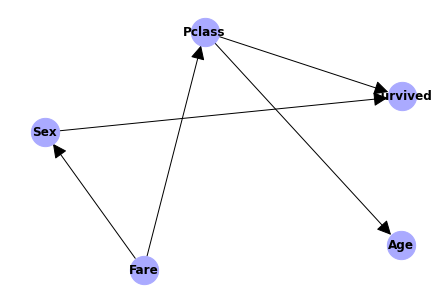

In [ ]:
draw_pgm(best_model)

  0%|          | 0/1000000 [00:00<?, ?it/s]

[('Survived', 'Sex'), ('Pclass', 'Fare'), ('Pclass', 'Age'), ('Pclass', 'Survived'), ('Pclass', 'Sex'), ('Sex', 'Fare')]


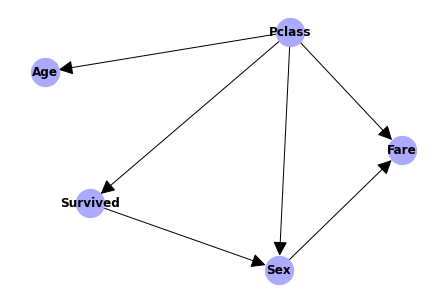

In [ ]:
hc = HillClimbSearch(df)
best_model_hill_bic = hc.estimate(scoring_method="bicscore")
print(best_model_hill_bic.edges())
draw_pgm(best_model_hill_bic)

  0%|          | 0/1000000 [00:00<?, ?it/s]

[('Survived', 'Age'), ('Pclass', 'Age'), ('Pclass', 'Survived'), ('Pclass', 'Sex'), ('Sex', 'Survived'), ('Fare', 'Pclass'), ('Fare', 'Sex'), ('Fare', 'Age')]


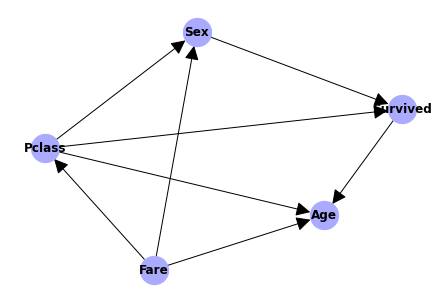

In [ ]:
hc = HillClimbSearch(df)
best_model_hill_k2 = hc.estimate(scoring_method="k2score")
print(best_model_hill_k2.edges())
draw_pgm(best_model_hill_k2)

# Exercise 3
(Adapted from "Artificial Intelligence, A Modern Approach")

Three soccer teams A, B, and C, play each other once. Each match is between two teams, and can be won, drawn, or lost. Each team has a fixed, unknown degree of quality—an integer ranging from 0 to 3—and the outcome of a match depends probabilistically on the difference in quality between the two teams.

* Construct the Bayesian network for modeling the three matches, specifying values for all the necessary probability distributions.
* Suppose that in the first two matches A beats B and B draws with C. Compute the posterior distribution for the outcome
of the third match.
* Compute the posterior distribution of the quality rating of A given that A won every match and B draws with C. 

## Solution

We use the following structure:
* We specify 3 variables, $A$, $B$, $C$ which correspond to the hidden skill level of each team.
* Then, we need to describe in some way the difference of skill level between the teams. While it would be tempting to use a single variable $D$, it would need to specify a conditional dependency between three variables, where it is not true that the difference in skill between $A$ and $B$ depends on $C$. Hence, we create 3 variables $DAB$, $DAC$, and $DBC$ which represent the difference in skill level between two teams.
* Finally, we use $MAB$, $MAC$, and $MBC$ to specify the outcome of the match, which depends only on the difference of two teams.
* We replicated the CPTs for each squad, difference, and match, since there should not be any *a priori* difference on their skill level.

In [ ]:
model = BayesianNetwork([('A','DAB'), ('B','DAB'), 
                         ('B','DBC'), ('C','DBC'), 
                         ('A','DAC'), ('C','DAC'), 
                         ('DAB','MAB'), 
                         ('DBC','MBC'), 
                         ('DAC','MAC')
                         ])

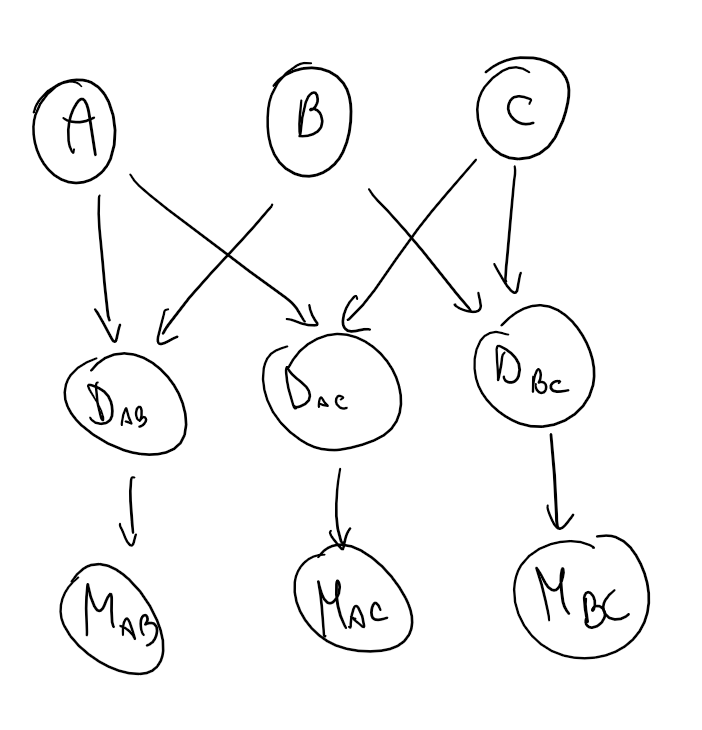

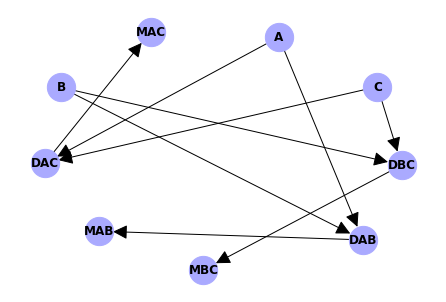

In [ ]:
draw_pgm(model)

In [ ]:
cpd_a = TabularCPD("A", 4, [[0.25]] * 4)
cpd_b = TabularCPD("B", 4, [[0.25]] * 4)
cpd_c = TabularCPD("C", 4, [[0.25]] * 4)
cpd_dab = TabularCPD(
    "DAB",
    7,
    [
        [0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0],  # diff: -3
        [0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0],  # diff: -2
        [0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0],  # diff: -1
        [1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1],  # diff:  0
        [0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0],  # diff: +1
        [0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0],  # diff: +2
        [0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0],  # diff: +3
    ],
    evidence=["A", "B"],  # list of variables needed as input to compute the conditional probabilities
    evidence_card=[4, 4],  # contains the cardinality of each variable needed as input
)

cpd_dbc = TabularCPD(
    "DBC",
    7,
    [
        [0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0],  # diff: -3
        [0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0],  # diff: -2
        [0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0],  # diff: -1
        [1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1],  # diff: -0
        [0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0],  # diff: +1
        [0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0],  # diff: +2
        [0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0],  # diff: +3
    ],
    evidence=["B", "C"],  # list of variables needed as input to compute the conditional probabilities
    evidence_card=[4, 4],  # contains the cardinality of each variable needed as input
)

cpd_dac = TabularCPD(
    "DAC",
    7,
    [
        [0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0],  # diff: -3
        [0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0],  # diff: -2
        [0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0],  # diff: -1
        [1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1],  # diff: -0
        [0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0],  # diff: +1
        [0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0],  # diff: +2
        [0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0],  # diff: +3
    ],
    evidence=["A", "C"],  # list of variables needed as input to compute the conditional probabilities
    evidence_card=[4, 4],  # contains the cardinality of each variable needed as input
)

cpd_mab = TabularCPD(
    "MAB",
    3,
    [
        [0.05,0.1,0.2,0.3,0.5,0.8,0.90],  # win
        [0.05,0.1,0.3,0.4,0.3,0.1,0.05],  # draw
        [0.90,0.8,0.5,0.3,0.2,0.1,0.05],  # loss
    ],
    evidence=["DAB"],  # list of variables needed as input to compute the conditional probabilities
    evidence_card=[7],  # contains the cardinality of each variable needed as input
)

cpd_mbc = TabularCPD(
    "MBC",
    3,
    [
        [0.05,0.1,0.2,0.3,0.5,0.8,0.90],  # win
        [0.05,0.1,0.3,0.4,0.3,0.1,0.05],  # draw
        [0.90,0.8,0.5,0.3,0.2,0.1,0.05],  # loss
    ],
    evidence=["DBC"],  # list of variables needed as input to compute the conditional probabilities
    evidence_card=[7],  # contains the cardinality of each variable needed as input
)


cpd_mac = TabularCPD(
    "MAC",
    3,
    [
        [0.05,0.1,0.2,0.3,0.5,0.8,0.90],  # win
        [0.05,0.1,0.3,0.4,0.3,0.1,0.05],  # draw
        [0.90,0.8,0.5,0.3,0.2,0.1,0.05],  # loss
    ],
    evidence=["DAC"],  # list of variables needed as input to compute the conditional probabilities
    evidence_card=[7],  # contains the cardinality of each variable needed as input
)

# Associating the CPDs with the network structure.
model.add_cpds(cpd_a, cpd_b, cpd_c, cpd_dab, cpd_dac, cpd_dbc, cpd_mab, cpd_mac, cpd_mbc)

In [ ]:
from pgmpy.inference import VariableElimination

infer = VariableElimination(model)
posterior_p = infer.query(["MAC"], evidence={"MAB": 0, "MBC": 1})
print(posterior_p)

posterior_p = infer.query(["A"], evidence={"MAB": 0, "MBC": 1, 'MAC': 0})
print(posterior_p)


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

+--------+------------+
| MAC    |   phi(MAC) |
+========+============+
| MAC(0) |     0.5017 |
+--------+------------+
| MAC(1) |     0.2370 |
+--------+------------+
| MAC(2) |     0.2614 |
+--------+------------+


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

+------+----------+
| A    |   phi(A) |
+======+==========+
| A(0) |   0.0399 |
+------+----------+
| A(1) |   0.1104 |
+------+----------+
| A(2) |   0.2915 |
+------+----------+
| A(3) |   0.5582 |
+------+----------+
